# CLASIFICACIÓN

## Regresión Logística

In [437]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

### Carga y análisis de datos

In [ ]:
# Cargamos el CSV en un DataFrame
df = pd.read_csv("marketing_campaign.csv", sep= '\t')
# Analisis exploratorio de los datos (EDA)

# Analisis exploratorio de los datos (EDA)
print(df.info())
print(df.describe())
print(df.head())

# Se analiza las variables categóricas
categoricas = ['Education', 'Marital_Status']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Limpieza de datos




In [439]:
# Se dropea la variable tipo Date y los valores en blanco

df = df.drop(columns='Dt_Customer', axis=0)
df = df.dropna()

### Conclusión EDA
-   No se han encontrado valores nulos
-   No se aprecian valores atípicos los cuales no sean representativos
-   Hay muchas variables binarias (menos para escalar y encodear)

### Preprocesamiento y división de los datos


In [440]:
# Encodeamiento de las variables categóricas

df_encodeado = pd.get_dummies(df['Education'], drop_first=True)
df_encodeado = pd.get_dummies(df['Marital_Status'], drop_first=True)
df = pd.concat([df, df_encodeado], axis=1)
df = df.drop(columns=categoricas)
print(df.info())

# Definimos las variables predictoras y objetivo
X = df.drop(columns=["Response"])
y = df["Response"]

# Escalamiento de las variables numéricas
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(f"Tamaño de X_scaled: {X.shape}, Tamaño de y: {y.shape}") # Asegurar que X e y tienen el mismo número de filas

# División de datos entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   MntWines             2216 non-null   int64  
 7   MntFruits            2216 non-null   int64  
 8   MntMeatProducts      2216 non-null   int64  
 9   MntFishProducts      2216 non-null   int64  
 10  MntSweetProducts     2216 non-null   int64  
 11  MntGoldProds         2216 non-null   int64  
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   int64 

 No hace falta mapear dado que las columnas binarias vienen en valores booleanos.

### Entrenamiento del modelo

In [441]:

# _____________BALANCEO DE CLASES_____________

# Algoritmo de sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Algoritmo de SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Algoritmo de submuestreo aleatorio
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Algoritmo de NearMiss (submuestreo basado en distancia)
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)

print(y_train.info())

# _____________EVALUACIÓN DE MÉTODOS DE BALANCEO_____________


resultados_balanceo = {}

def evaluar_balanceo(X_train_resampled, y_train_resampled, metodo):
    model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100
    resultados_balanceo[metodo] = (f1, auc)
    print(f"\nResultados con {metodo}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC-ROC: {auc:.2f}%")



evaluar_balanceo(X_train_ros, y_train_ros, "Sobremuestreo Aleatorio")
evaluar_balanceo(X_train_smote, y_train_smote, "SMOTE")
evaluar_balanceo(X_train_rus, y_train_rus, "Submuestreo Aleatorio")
evaluar_balanceo(X_train_nm, y_train_nm, "NearMiss")

# Seleccionar el mejor método de balanceo
mejor_metodo = max(resultados_balanceo, key=lambda k: resultados_balanceo[k])
print(f"\nEl mejor método de balanceo es: {mejor_metodo} con F1-Score: {resultados_balanceo[mejor_metodo][0]:.2f}% y AUC-ROC: {resultados_balanceo[mejor_metodo][1]:.2f}%")

# Obtener los datos balanceados del mejor método encontrado
if mejor_metodo == "Sobremuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_ros, y_train_ros
elif mejor_metodo == "SMOTE":
    X_train_resampled, y_train_resampled = X_train_smote, y_train_smote
elif mejor_metodo == "Submuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_rus, y_train_rus
elif mejor_metodo == "NearMiss":
    X_train_resampled, y_train_resampled = X_train_nm, y_train_nm

# ________________MÉTODO 1: Ajuste manual de hiperparámetros________________
manual_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)  # Ejemplo de hiperparámetros ajustados manualmente
manual_model.fit(X_train_resampled, y_train_resampled)  # Entrenar modelo

# Predicciones
y_pred_manual = manual_model.predict(X_test)

# Evaluación del modelo ajustado manualmente
print("\nResultados con ajuste manual de hiperparámetros:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, manual_model.predict_proba(X_test)[:,1]) * 100:.2f}%")


# ________________MÉTODO 2: Ajuste automático con GridSearchCV________________
parametros = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Diferentes valores de regularización
    "solver": ["liblinear", "lbfgs"]  # Diferentes algoritmos de optimización
}

# Configurar GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=500), parametros, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)  # Entrenar búsqueda de hiperparámetros

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

# Evaluación del mejor modelo
print("\nResultados con ajuste automático de hiperparámetros:")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_best) * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_best) * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]) * 100:.2f}%")


# ________________ENTRENAMIENTO FINAL Y EVALUACIÓN________________

# Entrenar el mejor modelo con los datos balanceados
best_model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones finales con el mejor modelo y el mejor balanceo
y_pred_final = best_model.predict(X_test)

# Crear DataFrame de resultados
resultados = pd.DataFrame({
    "Real": y_test.values,
    "Predicción": y_pred_final
})

# Mapear valores 0 y 1 a etiquetas comprensibles
resultados["Real"] = resultados["Real"].map({0: "Benigno", 1: "Maligno"})
resultados["Predicción"] = resultados["Predicción"].map({0: "Benigno", 1: "Maligno"})

# Mostrar las primeras filas de la tabla
print(resultados.head(10))






<class 'pandas.core.series.Series'>
Index: 1551 entries, 331 to 873
Series name: Response
Non-Null Count  Dtype
--------------  -----
1551 non-null   int64
dtypes: int64(1)
memory usage: 24.2 KB
None

Resultados con Sobremuestreo Aleatorio:
Accuracy: 79.40%
Precision: 39.38%
Recall: 79.17%
F1-Score: 52.60%
AUC-ROC: 85.93%

Resultados con SMOTE:
Accuracy: 80.30%
Precision: 40.64%
Recall: 79.17%
F1-Score: 53.71%
AUC-ROC: 85.91%

Resultados con Submuestreo Aleatorio:
Accuracy: 77.29%
Precision: 37.33%
Recall: 84.38%
F1-Score: 51.76%
AUC-ROC: 85.86%

Resultados con NearMiss:
Accuracy: 57.29%
Precision: 23.60%
Recall: 87.50%
F1-Score: 37.17%
AUC-ROC: 75.70%

El mejor método de balanceo es: SMOTE con F1-Score: 53.71% y AUC-ROC: 85.91%

Resultados con ajuste manual de hiperparámetros:
Accuracy: 80.30%
Precision: 40.64%
Recall: 79.17%
F1-Score: 53.71%
AUC-ROC: 85.91%

Resultados con ajuste automático de hiperparámetros:
Mejores parámetros: {'C': 0.1, 'solver': 'liblinear'}
Mejor Accuracy en va

##### _____________ENTRENAMIENTO FINAL Y EVALUACIÓN_____________

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       569
           1       0.41      0.79      0.54        96

    accuracy                           0.80       665
   macro avg       0.68      0.80      0.71       665
weighted avg       0.88      0.80      0.83       665



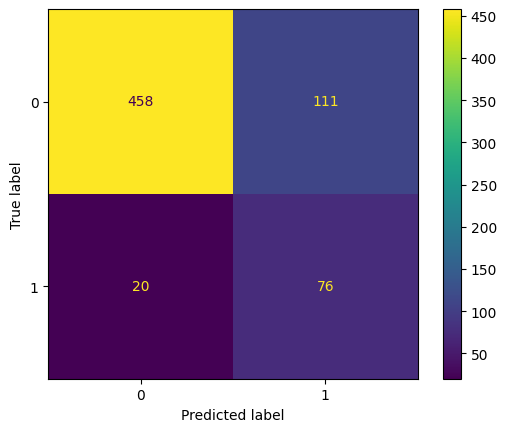

In [442]:
# _____________ENTRENAMIENTO FINAL Y EVALUACIÓN_____________


# Se entrena el mejor modelo con los datos balanceados
best_model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones finales con el mejor modelo y el mejor balanceo
y_pred_final = best_model.predict(X_test)

# Mostramos el reporte de la clasificación
print(classification_report(y_test, y_pred_final))

# Matriz de confusión
matrix = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


## Árboles de decisión para clasificación

Accuracy: 83.46%


[Text(0.7803522423852848, 0.975, 'x[19] <= 0.5\ngini = 0.259\nsamples = 1551\nvalue = [1314, 237]'),
 Text(0.6334892948971519, 0.925, 'x[17] <= 0.5\ngini = 0.206\nsamples = 1434\nvalue = [1267, 167]'),
 Text(0.7069207686412183, 0.95, 'True  '),
 Text(0.45843428599683544, 0.875, 'x[5] <= 18.5\ngini = 0.174\nsamples = 1348\nvalue = [1218, 130]'),
 Text(0.21855221518987342, 0.825, 'x[16] <= 8.5\ngini = 0.329\nsamples = 255\nvalue = [202, 53]'),
 Text(0.20589398734177214, 0.775, 'x[14] <= 0.5\ngini = 0.299\nsamples = 246\nvalue = [201, 45]'),
 Text(0.19956487341772153, 0.725, 'gini = 0.0\nsamples = 70\nvalue = [70, 0]'),
 Text(0.21222310126582278, 0.725, 'x[20] <= 0.5\ngini = 0.381\nsamples = 176\nvalue = [131, 45]'),
 Text(0.17444620253164558, 0.675, 'x[15] <= 7.5\ngini = 0.36\nsamples = 170\nvalue = [130, 40]'),
 Text(0.11787974683544304, 0.625, 'x[11] <= 126.0\ngini = 0.431\nsamples = 105\nvalue = [72, 33]'),
 Text(0.1115506329113924, 0.575, 'x[27] <= 0.5\ngini = 0.397\nsamples = 99\nva

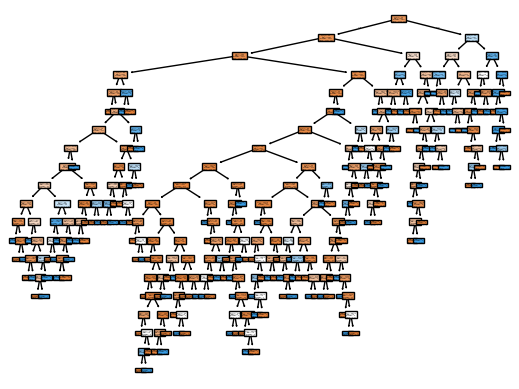

In [443]:
# Importar librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree


# Definimos las variables predictoras y objetivo
X = df.drop(columns=["Response"])
y = df['Response']  # Etiquetas (respuesta)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualizar el árbol de decisión
tree.plot_tree(model, filled=True) # La función plot_tree nos permite visualizar el árbol de decisión para ver cómo el modelo toma decisiones en función de las características. filled=True colorea los nodos para distinguir mejor las clases, feature_names asigna nombres a las características, class_name asigna nombres a las clases.


### Conclusiones de los Modelos de Clasificación usados:

Ambos modelos parecen tener una 'accuracy' parecida, siendo 'Árboles' un pelín superior. Sin embargo, se nota más rapidez en el modelo de logística (0.1s vs 8.2s). 

Mi conclusión personal es que se pueden usar ambos modelos a esta escala sin problema, sin embargo si el dataset fuera más grande, al tener accuracy parecida, usaría 'Logística' sobre 'Árboles' por tema de rapidez de análisis.

# REGRESIÓN

## Regresión lineal múltiple

In [460]:
#Se importan librerías necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Analisis exploratorio de los datos (EDA)
print(df.info())
print(df.describe())
print(df.head())

# Se hace concat para sumar todas las columnas de gastos
df['Total_Spending']= df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
# Seleccionar las variables independientes y la variable objetivo
X = df.drop(columns=["Total_Spending"])  # Variables independientes
y = df["Total_Spending"]  # Variable objetivo


# Escalar las variables para mejorar la estabilidad del modelo ya que no están en la misma medida y el modelo no usa regularización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Tamaño de X_scaled: {X_scaled.shape}, Tamaño de y: {y.shape}") # Asegurar que X_scaled y y tienen el mismo número de filas

# Agregar la variable objetivo nuevamente al DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["Total_Spending"] = y

# Calcular la correlación de las variables con el precio de la vivienda
correlaciones = df_scaled.corr()["Total_Spending"].sort_values(ascending=False)

# Mostrar la correlación de cada variable con la variable objetivo
print("Correlaciones con la variable objetivo:")
print(correlaciones)


# Calcular el VIF para cada variable independiente
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Mostrar los resultados
print("VIF de cada variable:")
print(vif_data)


# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener los coeficientes
coeficientes = pd.Series(modelo.coef_, index=X.columns)

# Mostrar el intercepto y los coeficientes
print("Intercepto:", modelo.intercept_)
print("Coeficientes:")
print(coeficientes)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   MntWines             2216 non-null   int64  
 7   MntFruits            2216 non-null   int64  
 8   MntMeatProducts      2216 non-null   int64  
 9   MntFishProducts      2216 non-null   int64  
 10  MntSweetProducts     2216 non-null   int64  
 11  MntGoldProds         2216 non-null   int64  
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   int64 

c:\Users\adria\Documents\GitHub\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Accuracy: 11.58%


[Text(0.48628518569409546, 0.9666666666666667, 'x[6] <= 160.5\nentropy = 9.345\nsamples = 1551\nvalue = [1, 2, 3, 1, 4, 3, 1, 5, 2, 8, 10, 8, 6, 4\n12, 6, 11, 10, 6, 8, 2, 3, 8, 4, 6, 5, 8, 2\n9, 3, 4, 8, 12, 5, 4, 8, 7, 8, 13, 9, 12, 9\n10, 9, 7, 4, 4, 4, 9, 8, 3, 13, 2, 5, 4, 5\n5, 7, 3, 7, 5, 7, 5, 7, 4, 5, 4, 1, 4, 5\n4, 7, 5, 4, 5, 1, 2, 4, 3, 2, 2, 3, 2, 4\n4, 2, 2, 3, 6, 1, 4, 4, 2, 4, 5, 5, 2, 1\n3, 3, 1, 2, 1, 2, 3, 3, 5, 1, 4, 1, 1, 1\n3, 3, 1, 2, 2, 2, 5, 3, 1, 1, 1, 1, 1, 1\n1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1\n3, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1\n1, 1, 3, 1, 2, 2, 1, 2, 3, 2, 1, 4, 3, 3\n1, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 2, 2, 2\n1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2\n2, 2, 1, 2, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1\n2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1\n2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 1, 1\n1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1\n1, 2, 1, 4, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2\n2, 1, 3, 2, 3, 1, 1, 1, 2, 2, 1, 3, 2, 2\n1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1\n3, 1

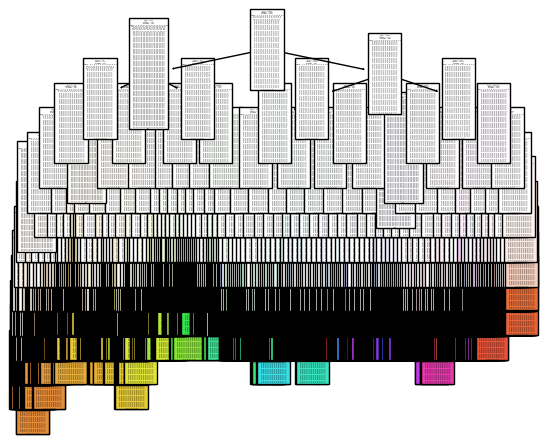

In [461]:
# Importar librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Se hace concat para sumar todas las columnas de gastos
df['Total_Spending']= df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
# Seleccionar las variables independientes y la variable objetivo
X = df.drop(columns=["Total_Spending"])  # Variables independientes
y = df["Total_Spending"]  # Variable objetivo

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42, criterion='entropy')

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualizar el árbol de decisión
tree.plot_tree(model, filled=True)

# Conclusiones

La parte de clasificación ha sido muy parecida y no había mucha diferencia entre ellas. La explicabilidad de los arboles es reducida en estos casos, por lo que yo utilizaría Regresión logistica para este modelo dados los buenos resultados obtenidos. 